In [ ]:
#importing libraries

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
from matplotlib import style
np.random.seed(42)

1. Load the data 


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#upload the json file for key and username (used in importing data set from kaggle)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raunakabhani","key":"725d3713b91495632f4f58f16cef2c63"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#link to dataset - https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 610M/612M [00:03<00:00, 163MB/s]
100% 612M/612M [00:03<00:00, 164MB/s]


In [ ]:
#unzip the imported dataset
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [ ]:
#assigning path for data set 
path_of_data="/content/"
train_path='Train'
test_path='Test'

In [ ]:
#finding total no of class
no_of_categories=len(os.listdir(train_path))
no_of_categories


43

In [ ]:
#label in data set using dictionary
classes = { 0:'Speed limit 20km/h',
            1:'Speed limit 30km/h', 
            2:'Speed limit 50km/h', 
            3:'Speed limit 60km/h', 
            4:'Speed limit 70km/h', 
            5:'Speed limit 80km/h', 
            6:'End of speed limit 80km/h', 
            7:'Speed limit 100km/h', 
            8:'Speed limit 120km/h', 
            9:'No passing', 
            10:'No passing for vechiles over 3.5 metric tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Vechiles over 3.5 metric tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End of no passing by vechiles over 3.5 metric tons' }

2.Visualize the dataset 

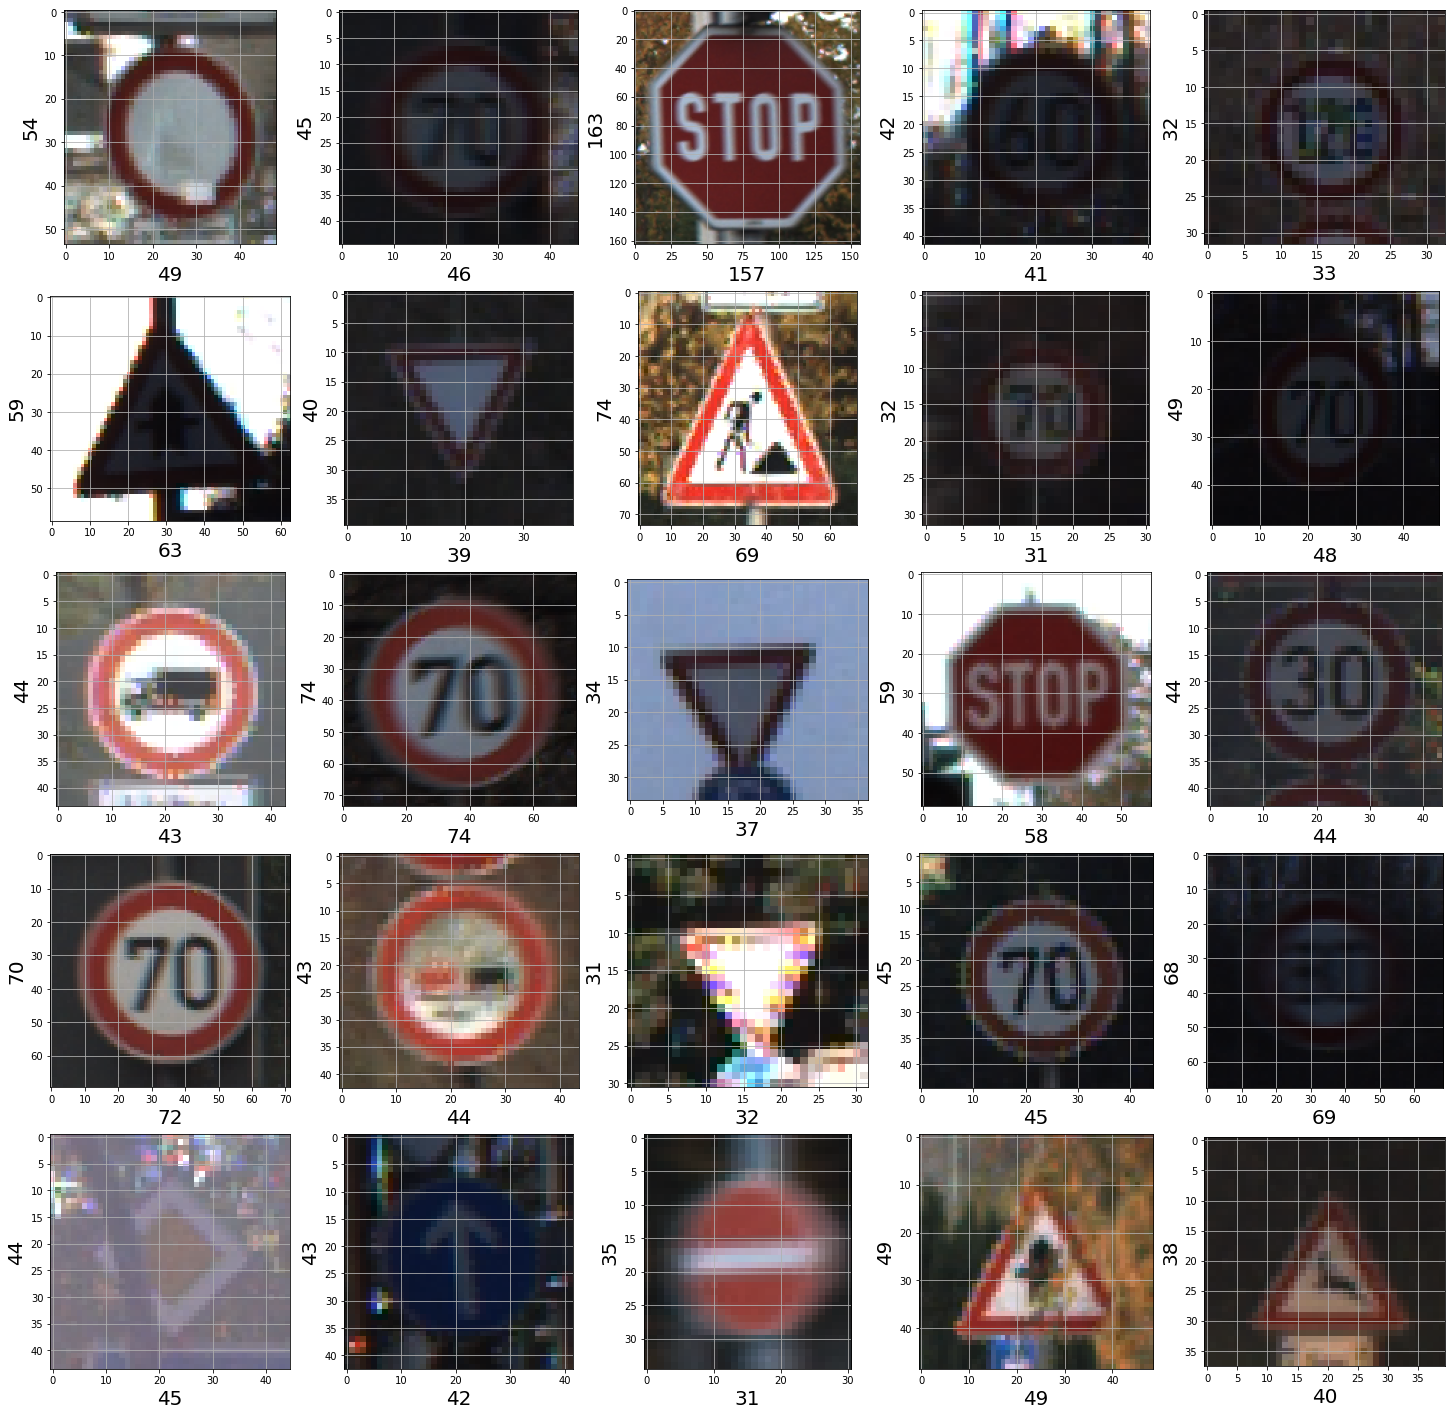

In [ ]:

import random
from matplotlib.image import imread

test = pd.read_csv(path_of_data + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = path_of_data + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

Preprocessing the image

1. Grayscaling.
2. Local Histogram Equalization.
3. Normalization.
4. Shuffling the data

In [ ]:
def gray_scale(image):
  return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_normalize(image):
   image = np.divide(image, 255)
   return image
   
def local_histo_equalize(image):
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

In [ ]:
image_data = []
image_labels = []

for i in range(no_of_categories): 
    path_of_image_folder =path_of_data + 'Train/' + str(i)  #returns 43 paths of folder  
    images = os.listdir(path_of_image_folder)

    for img in images:
        try:
            image = cv2.imread(path_of_image_folder+ '/' + img)
            image_fromarray = Image.fromarray(image, mode='RGB')
            #img2 = preprocessing(image_fromarray)
            resize_image = image_fromarray.resize((32,32))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data[0].shape, image_labels.shape)


(32, 32, 3) (39209,)


In [ ]:
#Preprocessing the image
preprocessed_image=preprocess(image_data)
print(preprocessed_image[0].shape)

(32, 32, 1)


In [ ]:
#shuffle the training data

tf.random.set_seed(42)
tf.random.shuffle(image_data,seed=42)
tf.random.shuffle(image_labels,seed=42)


<tf.Tensor: shape=(39209,), dtype=int64, numpy=array([32,  2, 38, ...,  3, 18, 40])>

In [ ]:
#splitting the data into trainig and validation set
x_train,x_val,y_train,y_val=train_test_split(preprocessed_image,image_labels,test_size=0.3,random_state=42,shuffle=True)
x_train.shape

(27446, 32, 32, 1)

In [ ]:
#checking shape after splitting
print("X_train.shape", x_train.shape)
print("X_valid.shape", x_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 32, 32, 1)
X_valid.shape (11763, 32, 32, 1)
y_train.shape (27446,)
y_valid.shape (11763,)


In [ ]:
#one hot encoding
y_train=tf.keras.utils.to_categorical(y_train,no_of_categories)
y_val=tf.keras.utils.to_categorical(y_val,no_of_categories)


In [ ]:
#building the model 
tf.random.set_seed(42)

# 1.create model (#sequential model type)
model_1=tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(32,32,1)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(axis=-1),
    
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(axis=-1),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(rate=0.5),
    
  tf.keras.layers.Dense(43, activation='softmax')
])

# 2.compile the model

epochs=30
lr=0.001
opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# 3.Fit the model
#Augmenting the data and training the model

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model_1.fit(aug.flow(x_train, y_train, batch_size=32), epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
858/858 [==============================] - 26s 17ms/step - loss: 1.0975 - accuracy: 0.7036 - val_loss: 0.2428 - val_accuracy: 0.9235
Epoch 2/30
858/858 [==============================] - 14s 17ms/step - loss: 0.2184 - accuracy: 0.9334 - val_loss: 0.0470 - val_accuracy: 0.9870
Epoch 3/30
858/858 [==============================] - 14s 16ms/step - loss: 0.1369 - accuracy: 0.9594 - val_loss: 0.0741 - val_accuracy: 0.9765
Epoch 4/30
858/858 [==============================] - 14s 16ms/step - loss: 0.0948 - accuracy: 0.9707 - val_loss: 0.0527 - val_accuracy: 0.9838
Epoch 5/30
858/858 [==============================] - 15s 17ms/step - loss: 0.0813 - accuracy: 0.9746 - val_loss: 0.0207 - val_accuracy: 0.9947
Epoch 6/30
858/858 [==============================] - 13s 15ms/step - loss: 0.0702 - accuracy: 0.9783 - val_loss: 0.0207 - val_accuracy: 0.9940
Epoch 7/30
858/858 [==============================] - 13s 15ms/step - loss: 0.0591 - accuracy: 0.9809 - val_loss: 0.0340 - val_accuracy:

In [ ]:
model_1.save('traffice_sign_classification.h5') #saving the model

In [ ]:
#to download the model
from google.colab import files
files.download("traffice_sign_classification.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# STORE THE MODEL AS A PICKLE OBJECT FOR TESTING PURPOSE 
import pickle
pickle_out= open("traffice_sign_classification.p","wb")  # wb = WRITE BYTE
pickle.dump(model_1,pickle_out)
pickle_out.close()
cv2.waitKey(0)

INFO:tensorflow:Assets written to: ram://ee6d71f5-d797-4864-80bf-e19f373063af/assets


-1

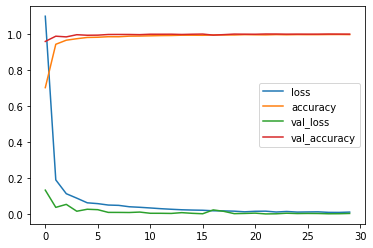

In [ ]:
#evaluating the model
import pandas as pd
pd.DataFrame(history.history).plot()

In [ ]:
#Loading the test data and running the predictions
test = pd.read_csv(path_of_data + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(path_of_data + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred_x = model_1.predict(X_test)
classes_x=np.argmax(pred_x,axis=1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print('Test Data accuracy: ',accuracy_score(labels, classes_x)*100)

Test Data accuracy:  98.53523357086303


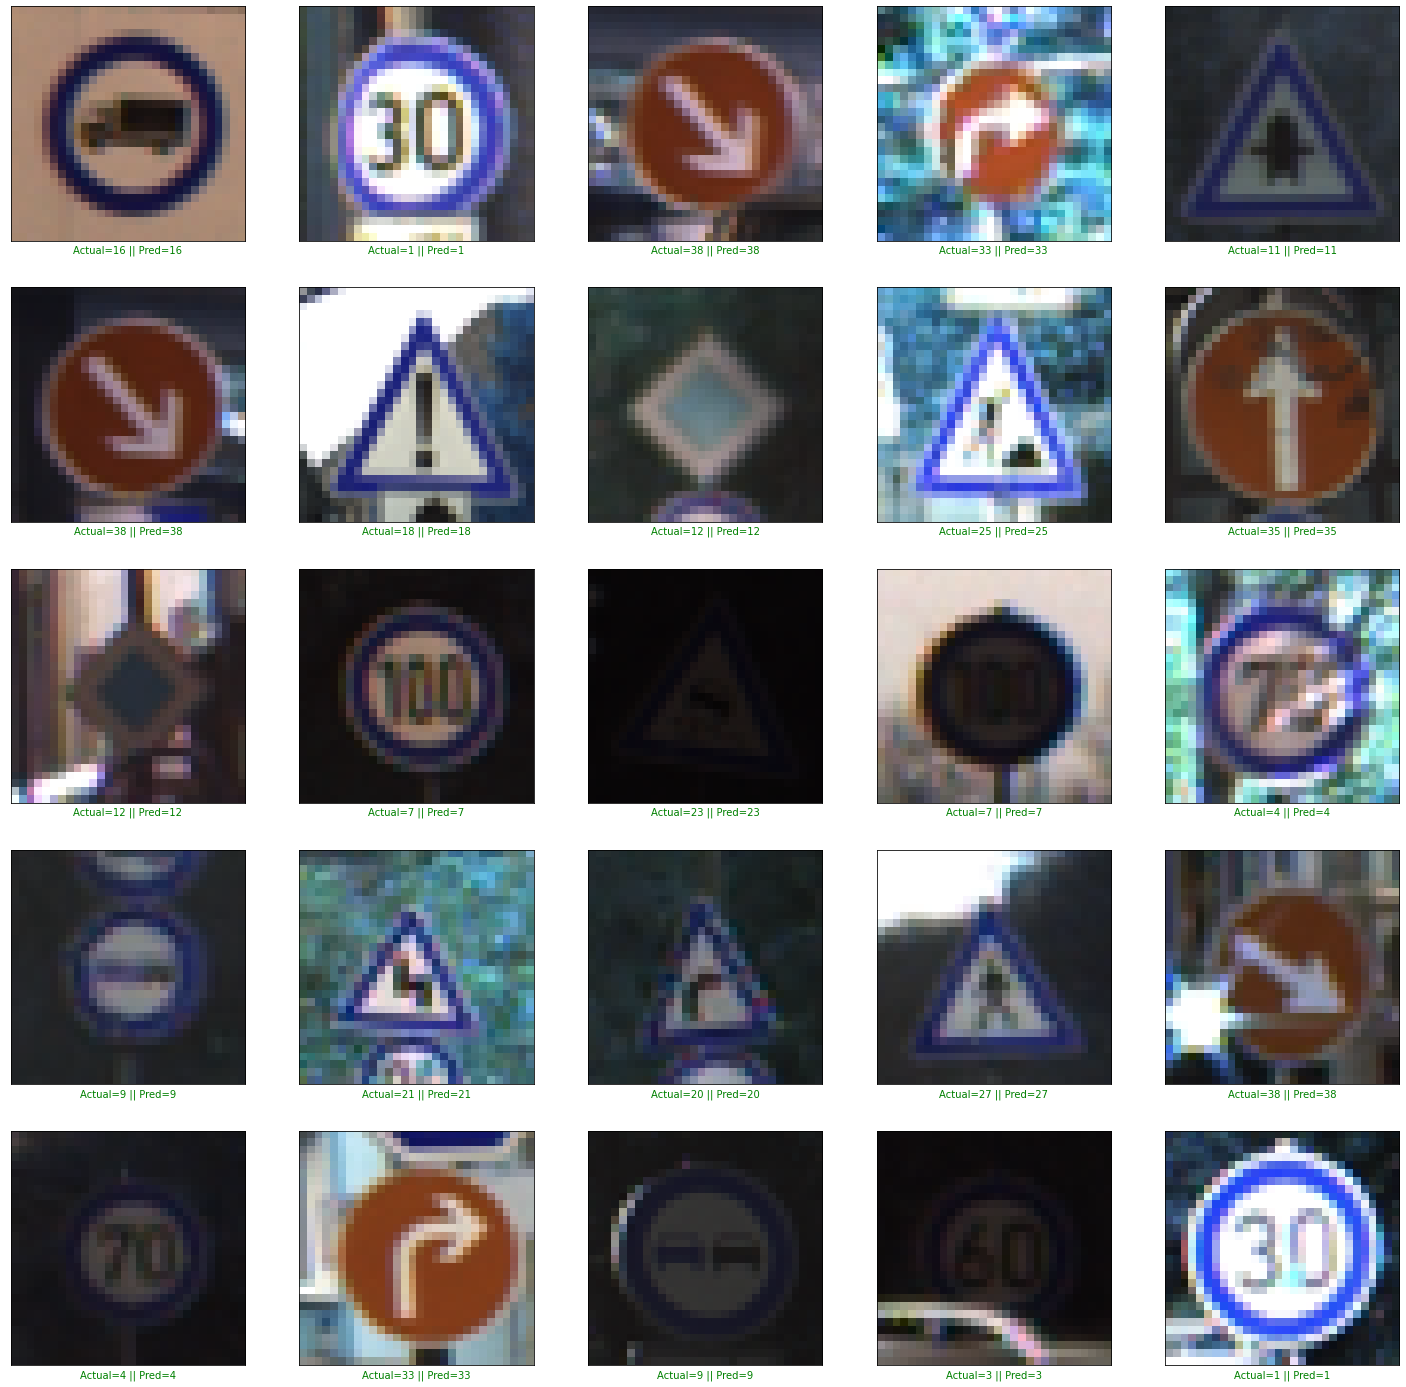

In [ ]:
#Predictions on Test Data
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classes_x[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()